In [9]:
import optuna
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from utilsforecast.evaluation import evaluate

import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Evaluación de métricas
def evaluate(cv_df, metrics):
    results = {}
    for metric in metrics:
        y_true = cv_df['y'].values
        y_pred = cv_df['ARIMA'].values
        results[metric.__name__] = metric(y_true, y_pred)
    return results

In [11]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [12]:
horizon = 24

In [13]:
# Definir función para optimización por ticker
def optimize_for_ticker(ticker):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    print(f"Number of observations for {ticker}: {len(Y_df_ticker)}")

    # Eliminar filas con NaN en la columna 'y'
    if Y_df_ticker['y'].isnull().any():
        print(f"NaN values found in {ticker}. Cleaning data...")
        Y_df_ticker = Y_df_ticker.dropna(subset=['y'])  


    # Diccionario para almacenar las métricas
    metrics_dict = {}

    # Definir función objetivo para Optuna
    def objective(trial):
        order = (trial.suggest_int('p', 0, 2), 
                 trial.suggest_int('d', 0, 1), 
                 trial.suggest_int('q', 0, 2))
        seasonal_order = (trial.suggest_int('P', 0, 1), 
                          trial.suggest_int('D', 0, 1), 
                          trial.suggest_int('Q', 0, 1))
        season_length = trial.suggest_int('season_length', 1, min(52, len(Y_df_ticker)))

        # Instanciar el modelo ARIMA
        model = ARIMA(order=order, seasonal_order=seasonal_order, season_length=season_length)

        sf = StatsForecast(df=Y_df_ticker, models=[model], freq='W', n_jobs=-1)

        # Validación cruzada
        cv_df = sf.cross_validation(df=Y_df_ticker, h=horizon, step_size=horizon, n_windows=5).reset_index()

        # Evaluación de las predicciones
        evaluation_results = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape, mape, mse, mae, rmse])

        # Guardar las métricas para el análisis posterior
        metrics_dict[trial.number] = {
            'smape': evaluation_results['smape'],
            'mape': evaluation_results['mape'],
            'mse': evaluation_results['mse'],
            'mae': evaluation_results['mae'],
            'rmse': evaluation_results['rmse']
        }

        return evaluation_results['smape']

    # Optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=25)

    best_params = study.best_params
    best_trial = study.best_trial.number

    print(f"Best hyperparameters for {ticker}: {best_params}")
    print(f"Best SMAPE for {ticker}: {study.best_value}")
    print(f"Metrics for the best trial ({best_trial}): {metrics_dict[best_trial]}")

    return best_params, metrics_dict[best_trial]

In [14]:
# Crear modelo y predecir
def create_model_and_predict(ticker, best_params):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    # Crear modelo final con los mejores parámetros
    final_model = ARIMA(
        order=(best_params['p'], best_params['d'], best_params['q']),
        seasonal_order=(best_params['P'], best_params['D'], best_params['Q']),
        season_length=best_params['season_length']
    )

    sf_final = StatsForecast(df=Y_df_ticker, models=[final_model], freq='W', n_jobs=-1)

    prediction_length = len(Y_df_ticker) - horizon
    Y_df_real = Y_df_ticker[:prediction_length]

    sf_final.fit(Y_df_real)
    forecast = sf_final.forecast(h=horizon)

    print(f"Predictions for {ticker}:")
    print(forecast)

    return forecast

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_predictions(ticker, forecast):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]
    
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Actual data (historical)
    real_series = Y_df_ticker[['ds', 'y']]  
    plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Predictions
    forecast_series = forecast[['ds', 'ARIMA']]
    plt.plot(forecast_series['ds'], forecast_series['ARIMA'], label='Prediction', marker='x', color='orange', linestyle='--', linewidth=2)

    # Configure the plot
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    
    # Set the x-axis limits to encompass both actual and forecast data
    all_dates = pd.concat([real_series['ds'], forecast_series['ds']])  # Define all_dates here
    plt.xlim([pd.Timestamp('2024-01-01'), all_dates.max() + pd.DateOffset(months=1)])  # Cutting the graph from January 1, 2024

    # Set the y-axis limit based on the ticker
    if ticker.lower() == 'nvda':
        plt.ylim(bottom=40)  # NVDA starts from 40
    elif ticker.lower() == 'btc-usd':
        plt.ylim(bottom=35000)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'msft':
        plt.ylim(bottom=340)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'amzn':
        plt.ylim(bottom=140)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'meta':
        plt.ylim(bottom=300)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'aapl':
        plt.ylim(bottom=140)  # BTC-USD starts from 30,000
    else:
        plt.ylim(bottom=120)  # All other tickers start from 150

    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [16]:
# Optimización para cada ticker
best_params_dict = {}
for ticker in tickers:
    print(f"\nOptimizando para {ticker}...")
    best_params, best_metrics = optimize_for_ticker(ticker)
    if best_params is not None:
        best_params_dict[ticker] = best_params


Optimizando para AAPL...
Number of observations for AAPL: 1294
Best hyperparameters for AAPL: {'p': 1, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 1, 'season_length': 33}
Best SMAPE for AAPL: 8.284767717123032
Metrics for the best trial (22): {'smape': 8.284767717123032, 'mape': 7.9381585121154785, 'mse': 349.31744, 'mae': 14.4868355, 'rmse': 18.690037}

Optimizando para MSFT...
Number of observations for MSFT: 1294
Best hyperparameters for MSFT: {'p': 2, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 1, 'season_length': 34}
Best SMAPE for MSFT: 6.6343992948532104
Metrics for the best trial (13): {'smape': 6.6343992948532104, 'mape': 6.336255371570587, 'mse': 811.91534, 'mae': 20.966425, 'rmse': 28.49413}

Optimizando para GOOGL...
Number of observations for GOOGL: 1052
Best hyperparameters for GOOGL: {'p': 2, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 0, 'season_length': 44}
Best SMAPE for GOOGL: 7.111174613237381
Metrics for the best trial (21): {'smape': 7.111174613237381, 'mape': 7.168462127447128, 'mse

In [17]:
# Crear y predecir
import time
forecasts_dict = {}

for ticker in tickers:
    if ticker in best_params_dict:
        print(f"\nCreando el modelo y realizando predicciones para {ticker}...")

        start_time = time.time()
        forecast = create_model_and_predict(ticker, best_params_dict[ticker])
        end_time = time.time()

        print(f"Tiempo de predicción para {ticker}: {end_time - start_time:.2f} segundos")
        forecasts_dict[ticker] = forecast


Creando el modelo y realizando predicciones para AAPL...
Predictions for AAPL:
                  ds       ARIMA
unique_id                       
AAPL      2024-04-28  183.419403
AAPL      2024-05-05  181.349182
AAPL      2024-05-12  183.920471
AAPL      2024-05-19  184.079163
AAPL      2024-05-26  181.916336
AAPL      2024-06-02  178.989838
AAPL      2024-06-09  186.202286
AAPL      2024-06-16  191.477188
AAPL      2024-06-23  194.797531
AAPL      2024-06-30  194.267181
AAPL      2024-07-07  193.132599
AAPL      2024-07-14  193.904526
AAPL      2024-07-21  194.990829
AAPL      2024-07-28  193.033707
AAPL      2024-08-04  191.765121
AAPL      2024-08-11  184.574310
AAPL      2024-08-18  186.939270
AAPL      2024-08-25  190.474640
AAPL      2024-09-01  191.472595
AAPL      2024-09-08  189.321304
AAPL      2024-09-15  189.235611
AAPL      2024-09-22  189.471756
AAPL      2024-09-29  188.709930
AAPL      2024-10-06  186.196198
Tiempo de predicción para AAPL: 17.60 segundos

Creando el mod


Graficando las predicciones para AAPL...


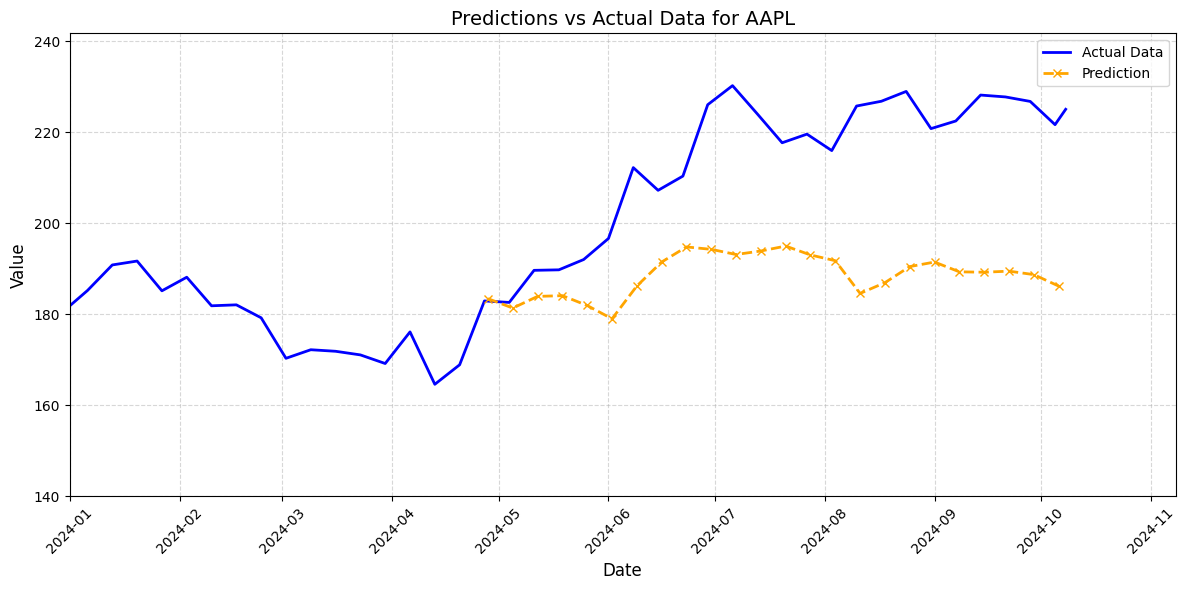


Graficando las predicciones para MSFT...


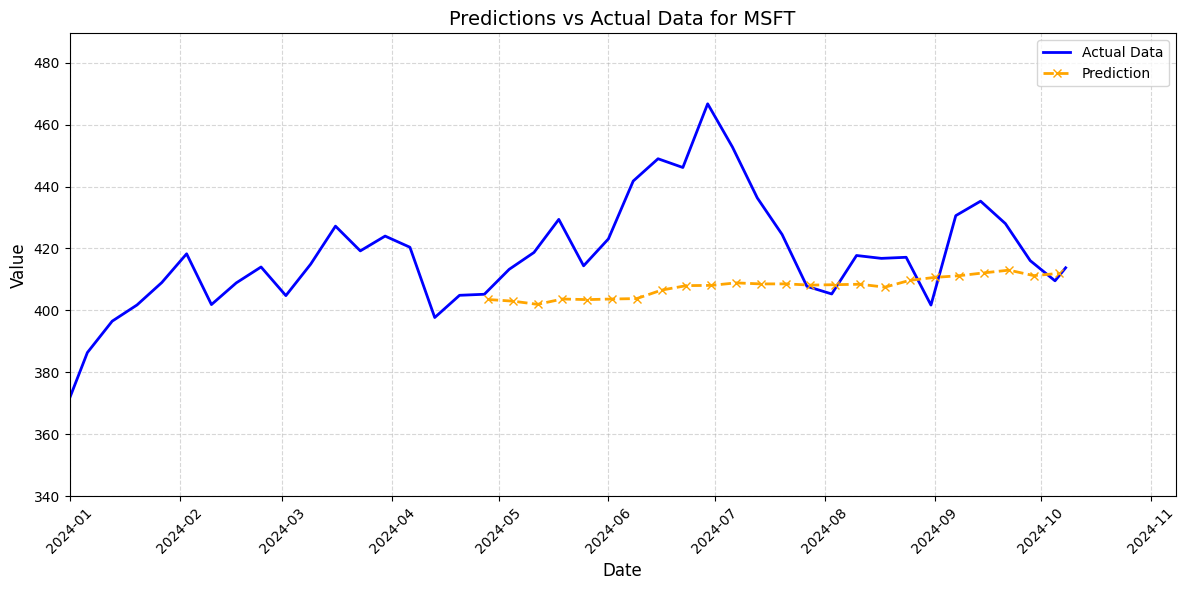


Graficando las predicciones para GOOGL...


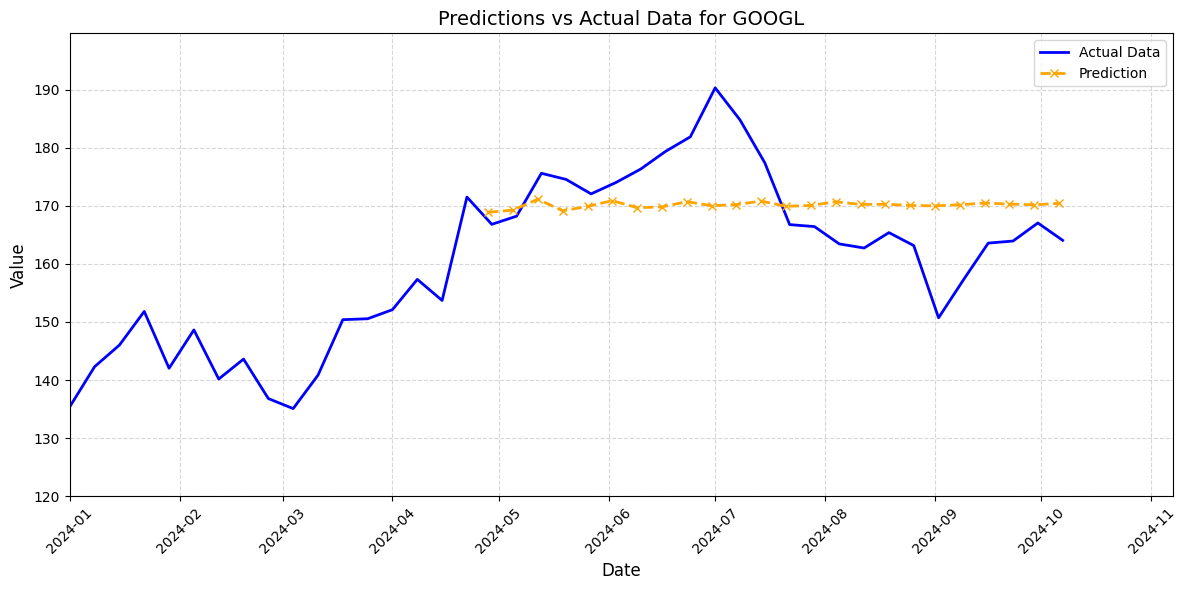


Graficando las predicciones para AMZN...


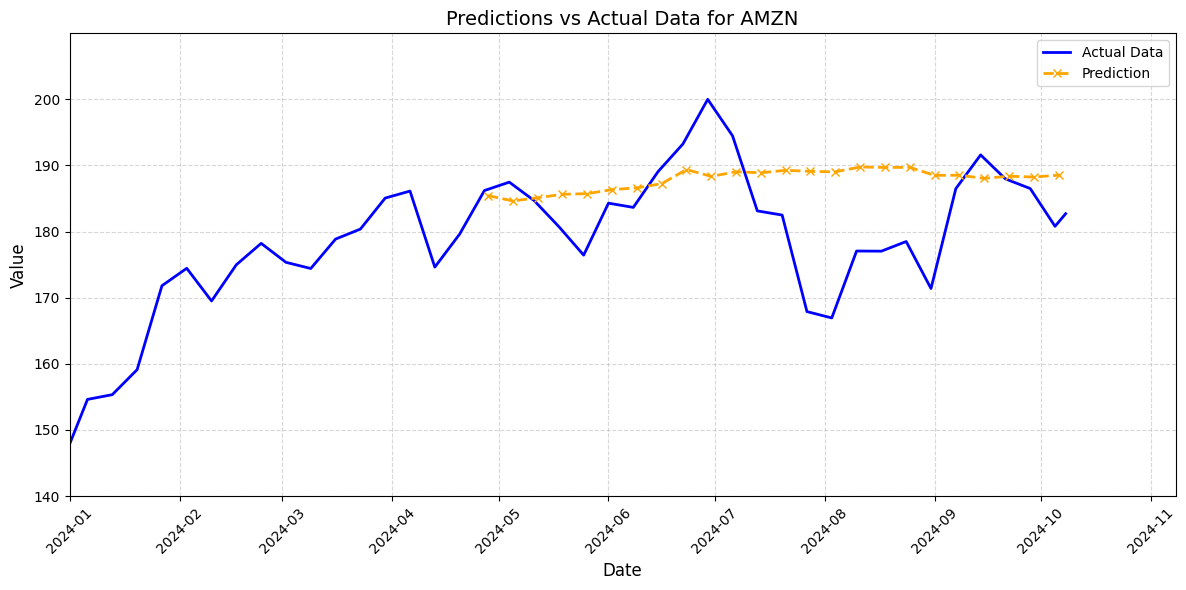


Graficando las predicciones para NVDA...


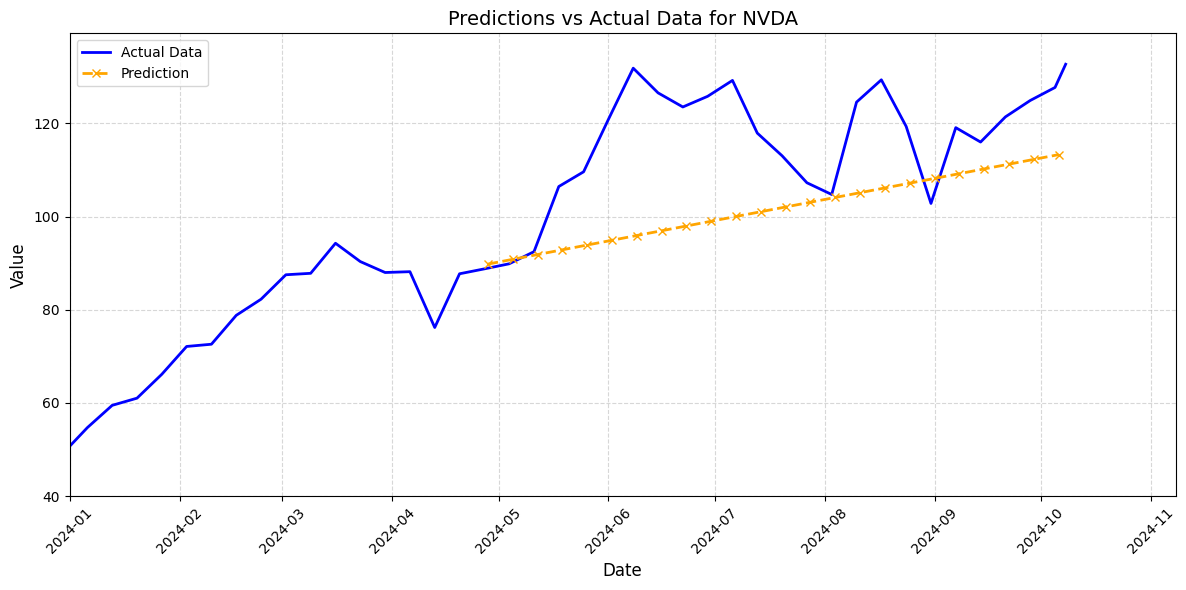


Graficando las predicciones para META...


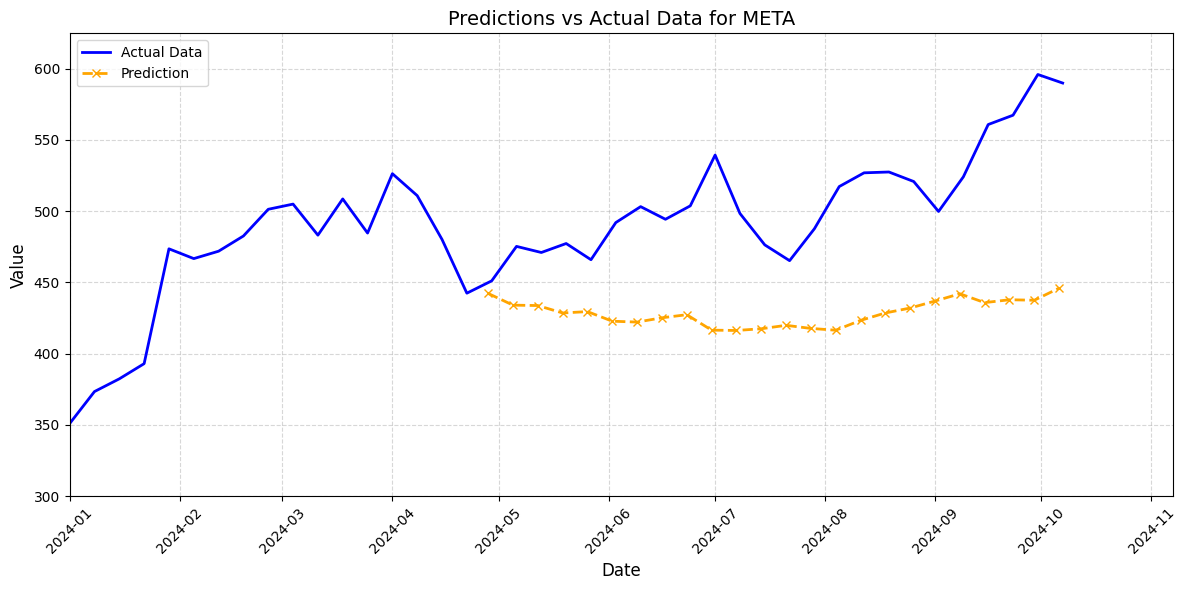


Graficando las predicciones para IBM...


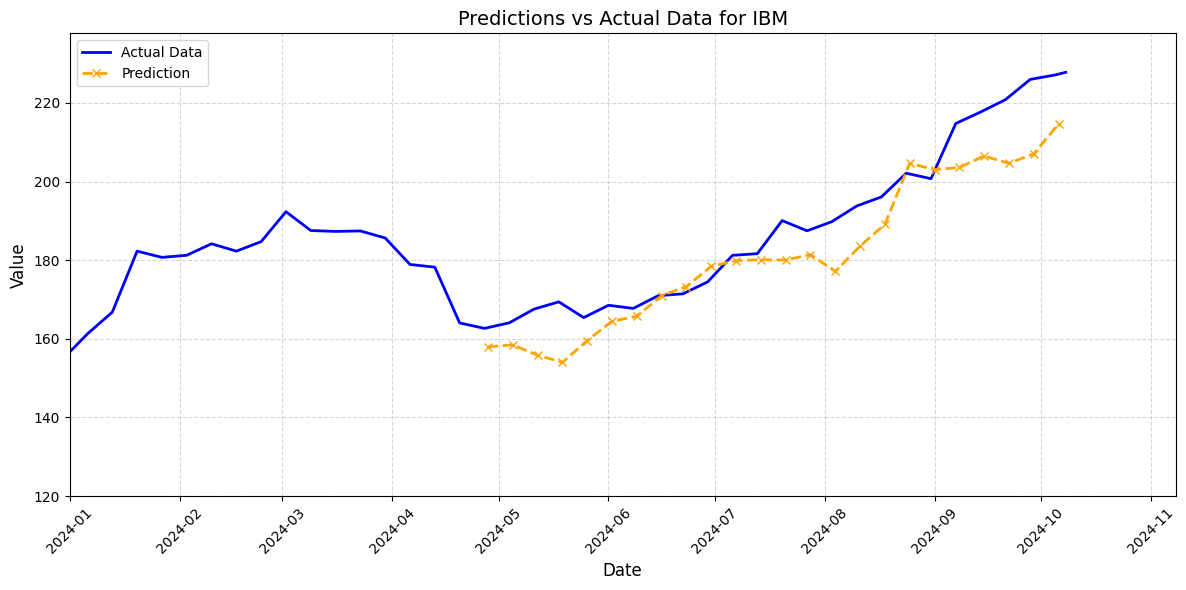


Graficando las predicciones para BTC-USD...


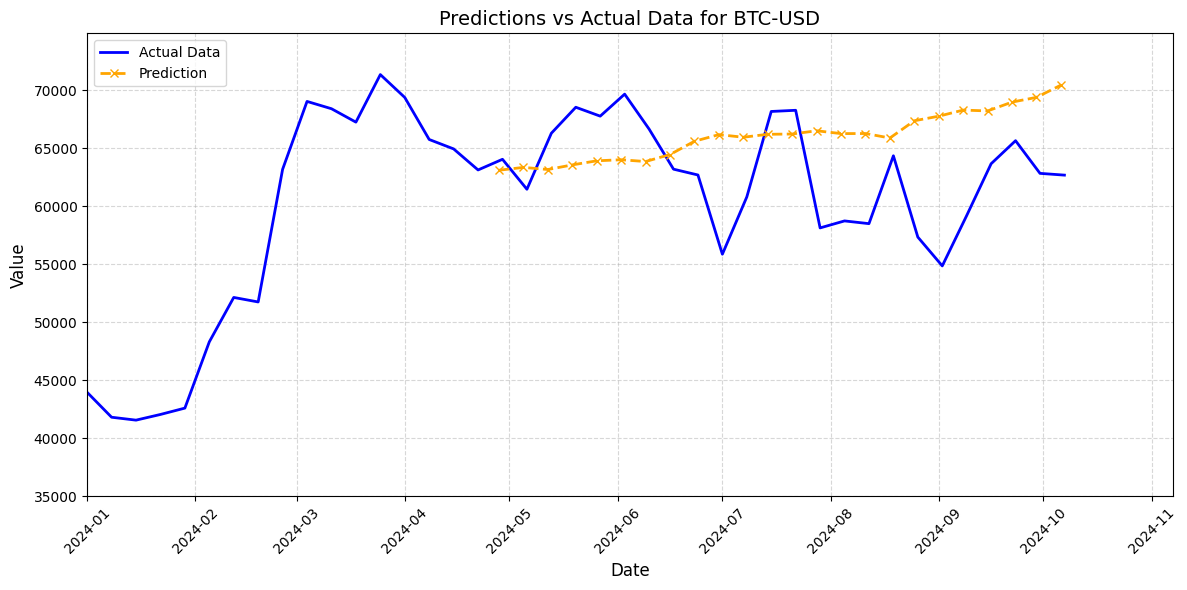

In [22]:
# Graficar resultados
for ticker in forecasts_dict:
    print(f"\nGraficando las predicciones para {ticker}...")
    plot_predictions(ticker, forecasts_dict[ticker])